In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense

In [35]:
train_path = 'disney_data/cartoon/train/'
test_path = 'disney_data/cartoon/test/'
val_path = 'disney_data/cartoon/val/'

image_gen = ImageDataGenerator(rescale=1/255.,horizontal_flip=True, rotation_range=30, shear_range=0.15)

In [36]:
train_gen = image_gen.flow_from_directory(train_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

test_gen = image_gen.flow_from_directory(test_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

val_gen = image_gen.flow_from_directory(val_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

Found 2017 images belonging to 5 classes.
Found 433 images belonging to 6 classes.
Found 706 images belonging to 5 classes.


C:\Users\user\AppData\Local\Temp\ipykernel_6800\2240004793.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


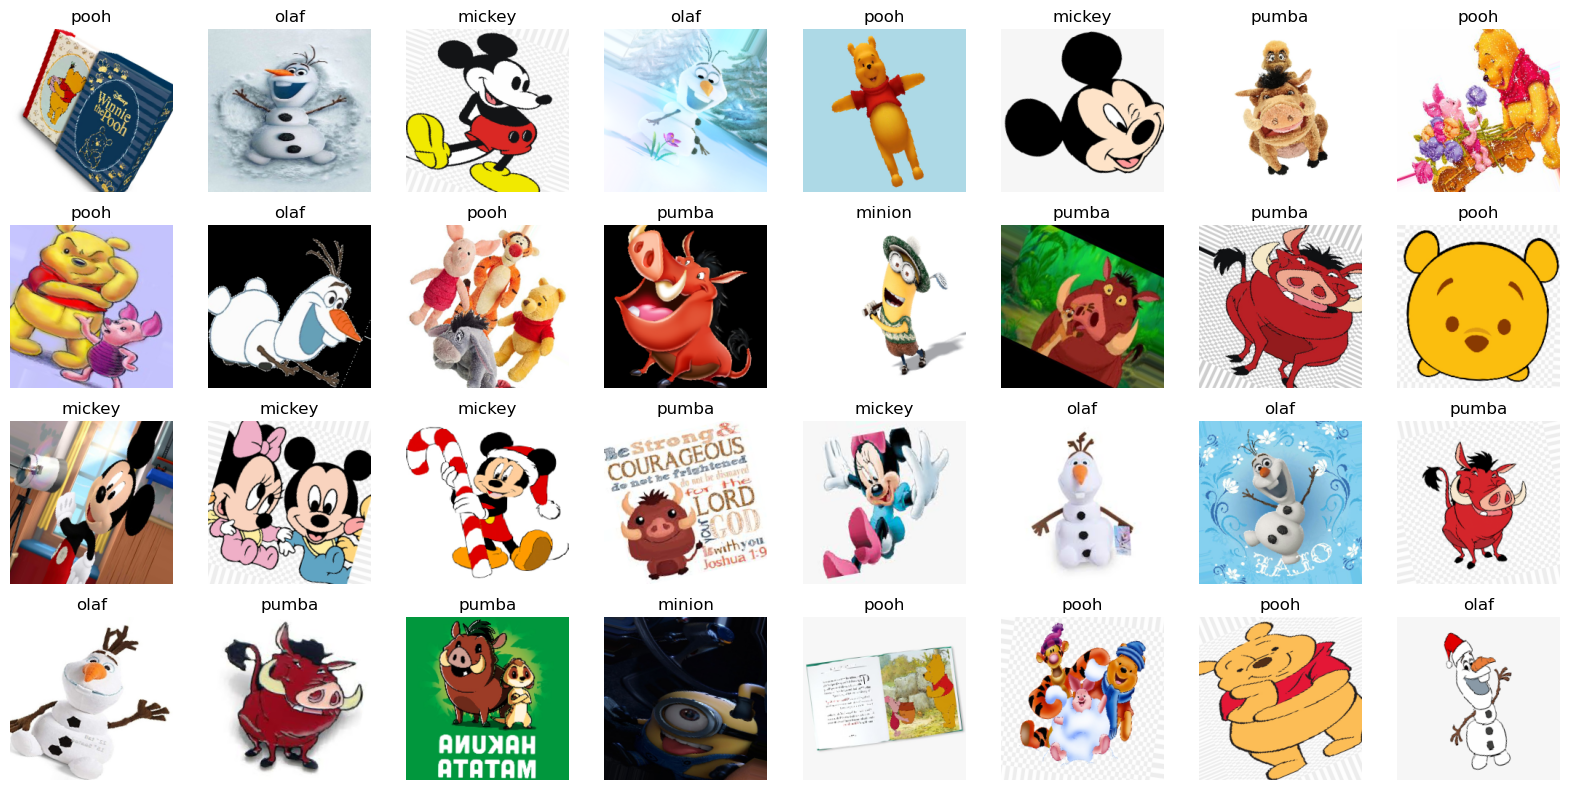

In [37]:
class_labels = os.listdir('disney_data/cartoon/train/')

batch = next(train_gen)
images,labels = batch[0],batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

    ax = plt.subplot(4,8,i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [38]:
class_labels

['mickey', 'minion', 'olaf', 'pooh', 'pumba']

In [39]:
from tensorflow.keras.applications import vgg19
vgg_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
for layer in vgg_model.layers:
    layer.trainable = False

In [41]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 26,448,453
Trainable params: 6,424,069
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
# 체크포인트 설정
checkpoint = ModelCheckpoint(filepath='checkpoint_weight.ckpt', save_weights_only=True, save_best_only=True, monitor='val_accuracy', verbose=1)

# 조기종료
earlystopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [43]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=10,
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/10


c:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/64 [==========>...................] - ETA: 3:12 - loss: 3.4230 - accuracy: 0.4087

c:\Users\user\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


64/64 [==============================] - ETA: 0s - loss: 1.8500 - accuracy: 0.5895
Epoch 1: val_accuracy improved from -inf to 0.67989, saving model to checkpoint_weight.ckpt
64/64 [==============================] - 541s 8s/step - loss: 1.8500 - accuracy: 0.5895 - val_loss: 0.7630 - val_accuracy: 0.6799
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7392
Epoch 2: val_accuracy improved from 0.67989 to 0.84136, saving model to checkpoint_weight.ckpt
64/64 [==============================] - 604s 9s/step - loss: 0.7151 - accuracy: 0.7392 - val_loss: 0.4934 - val_accuracy: 0.8414
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5439 - accuracy: 0.8061
Epoch 3: val_accuracy improved from 0.84136 to 0.88669, saving model to checkpoint_weight.ckpt
64/64 [==============================] - 675s 11s/step - loss: 0.5439 - accuracy: 0.8061 - val_loss: 0.3922 - val_accuracy: 0.8867
Epoch 4/10
64/64 [==============================] - ETA:

In [48]:
model.load_weights('checkpoint_weight.ckpt')
loss, acc = model.evaluate(test_gen, verbose=0)

print(loss)
print(acc)

0.17709533870220184
0.942148745059967


In [49]:
model.save('vgg_disney_model.h5')

In [77]:
class MyModel(Model):

    def __init__(self) :
        super(MyModel, self).__init__()

        self.input_layer = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3))
        self.conv32_layer = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.conv64_layer = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.conv128_layer = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.pooling_layer = MaxPooling2D(pool_size=(2, 2))
        self.flatten_layer = Flatten()
        self.dense_layer = Dense(256, activation='relu')
        self.drop_layer = Dropout(0.5)
        self.out_layer = Dense(5, activation='softmax')

    def call(self,x):
        print('Mymodel')

        layer = self.input_layer(x)
        layer = self.conv32_layer(layer)
        layer = self.conv64_layer(layer)
        layer = self.conv128_layer(layer)
        layer = self.pooling_layer(layer)
        layer = self.flatten_layer(layer)
        layer = self.dense_layer(layer)
        layer = self.drop_layer(layer)
        return self.out_layer(layer)


In [78]:
my_model = MyModel()

my_model(Input(shape=(224,224,3)))

Mymodel


<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'my_model_12')>

In [79]:
my_model.summary()

Model: "my_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          multiple                  896       
                                                                 
 conv2d_26 (Conv2D)          multiple                  9248      
                                                                 
 conv2d_27 (Conv2D)          multiple                  18496     
                                                                 
 conv2d_28 (Conv2D)          multiple                  73856     
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_18 (Flatten)        multiple                  0         
                                                       

In [80]:
my_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist2 = my_model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=10,
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/10
Mymodel
Mymodel
64/64 [==============================] - ETA: 0s - loss: 3.5385 - accuracy: 0.5721 Mymodel

Epoch 1: val_accuracy did not improve from 0.88669
64/64 [==============================] - 884s 13s/step - loss: 3.5385 - accuracy: 0.5721 - val_loss: 0.8002 - val_accuracy: 0.7380
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.8715 - accuracy: 0.6951 
Epoch 2: val_accuracy did not improve from 0.88669
64/64 [==============================] - 823s 13s/step - loss: 0.8715 - accuracy: 0.6951 - val_loss: 0.7323 - val_accuracy: 0.7408
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7680 
Epoch 3: val_accuracy did not improve from 0.88669
64/64 [==============================] - 838s 13s/step - loss: 0.6617 - accuracy: 0.7680 - val_loss: 0.5736 - val_accuracy: 0.8144
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.8245 
Epoch 4: val_accuracy did not improve from 0.88669

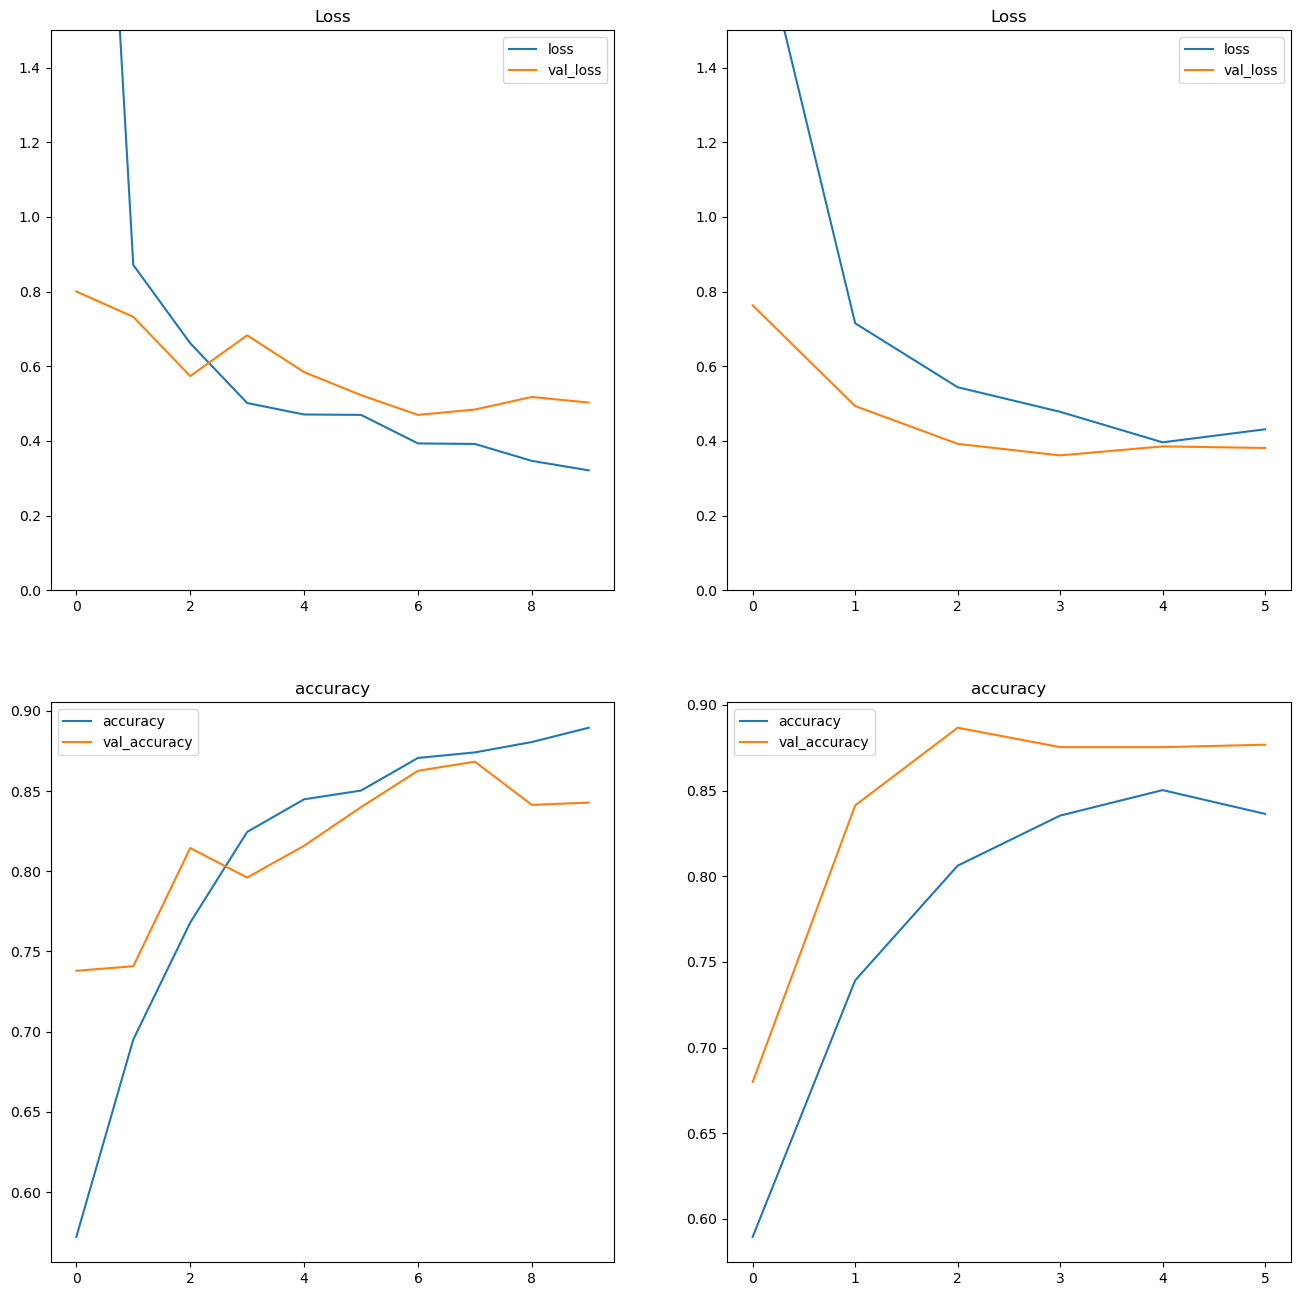

In [81]:
plt.figure(figsize=(16,16))

ax1 = plt.subplot(2,2,1)
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.ylim(0,1.5)
plt.title('Loss')
plt.legend()

ax2 = plt.subplot(2,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.ylim(0,1.5)
plt.title('Loss')
plt.legend()

ax3 = plt.subplot(2,2,3)
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()

ax4 = plt.subplot(2,2,4)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()


plt.show()

In [83]:
# my_model.load_weights('checkpoint_weight.ckpt')
loss, acc = my_model.evaluate(test_gen, verbose=0)

print(loss)
print(acc)

0.18468710780143738
0.939393937587738


In [ ]:
my_model.save('my_vgg_disney_model.h5')

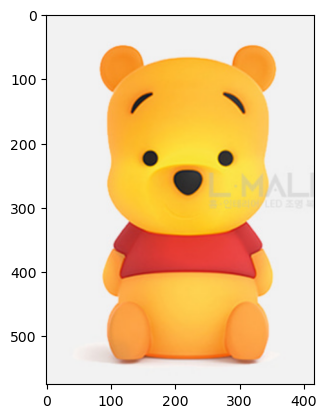

In [88]:
from PIL import Image

file = 'pred_p.png'

sample = Image.open(file)
plt.imshow(sample)

In [89]:


testImage = load_img(file, target_size=(224, 224))
imageArr = np.array(testImage)
imageArr = imageArr/255
imageArr = imageArr.reshape(-1, 224, 224, 3)

preds = model.predict(imageArr)
label = np.argmax(preds)

class_labels[label]

1/1 [==============================] - 0s 274ms/step


'pooh'

In [90]:
my_preds = my_model.predict(imageArr)
label = np.argmax(my_preds)

class_labels[label]

1/1 [==============================] - 0s 338ms/step


'pooh'